<h1>Чётенькое такси. Прогнозирование заказов.<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Осмотр-и-предобработка-данных." data-toc-modified-id="Осмотр-и-предобработка-данных.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Осмотр и предобработка данных.</a></span><ul class="toc-item"><li><span><a href="#Цель-и-задачи-проекта." data-toc-modified-id="Цель-и-задачи-проекта.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цель и задачи проекта.</a></span></li><li><span><a href="#Библиотеки." data-toc-modified-id="Библиотеки.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Библиотеки.</a></span></li><li><span><a href="#Загрузка-и-обзор-датасета." data-toc-modified-id="Загрузка-и-обзор-датасета.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка и обзор датасета.</a></span></li><li><span><a href="#Подготовка-временного-ряда." data-toc-modified-id="Подготовка-временного-ряда.-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовка временного ряда.</a></span></li><li><span><a href="#Ресемплинг-данных." data-toc-modified-id="Ресемплинг-данных.-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Ресемплинг данных.</a></span></li></ul></li><li><span><a href="#Анализ-данных.-Тренды.-Сезонность." data-toc-modified-id="Анализ-данных.-Тренды.-Сезонность.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных. Тренды. Сезонность.</a></span></li><li><span><a href="#Машинное-обучение-временного-ряда." data-toc-modified-id="Машинное-обучение-временного-ряда.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Машинное обучение временного ряда.</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Создание-признаков.-Обучение-моделей.-Поиск-лучших." data-toc-modified-id="Создание-признаков.-Обучение-моделей.-Поиск-лучших.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание признаков. Обучение моделей. Поиск лучших.</a></span></li><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке.-Выводы." data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке.-Выводы.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке. Выводы.</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li></ul></li></ul></div>

# Осмотр и предобработка данных.

## Цель и задачи проекта.

<b> Добро пожаловать в мой проект! </b>

Итак, 

<u>С чем мы сегодня работаем:</u>

Исторические данные из аэропортов по количеству заказов такси в единицу времени (какую единицу - увидим при загрузке). 

<u>Какова наша цель:</u>

Создать модель, качественно предсказываюущую количество заказов такси на ближайший час. Качественно - это не превысить значение 48 для метрики RMSE при оценке обучения тестовой выборки. Таким образом, решаем задачу регрессии для временного ряда.

<u>Какие задачи нужно выполнить для достижения цели:</u>

- Загрузить и обозреть датасет
- Предобработать данные:
    - Проверить на наличие пропусков, дубликатов, аномалий
    - Проверить правильность типов данных
    - Привести датасет к виду временного ряда с шагом в 1 час: сделать даты индексами, отсортировать и ресемплировать весь сет
- Проанализировать данные на предмет сезонности и трендов, проверить стационарность временного ряда
- Отделить обучающую и тестовую выборки друг от друга в соотношении 9 к 1
- Написать функцию, которая:
    - Искусственно создаст признаки для обучения: календарные, "отстающие", "скользящее среднее"
    - Удалит пропуски
    - Обучит случайный лес и простую линейную регрессию
    - Предскажет целевой признак для обучающей выборки
    - Вычислит RMSE для моделей
    - Будет перебирать окно скольжения среднего и сдвиг отставания значений и повторять указанные выше шаги
    - Результатом будут RMSE лучших моделей, и их лучшие параметры
- Выявить модель с минимальным значением RMSE и воздать ей все возможные почести


<b>Примечание: проект создавался локально, поэтому в коде указана ссылка на локальное расположение исходного csv. </b>

## Библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

## Загрузка и обзор датасета.

In [2]:
df = pd.read_csv("/datasets/taxi.csv")

In [3]:
print(df.head(10))
df.info()

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32
5  2018-03-01 00:50:00          21
6  2018-03-01 01:00:00           7
7  2018-03-01 01:10:00           5
8  2018-03-01 01:20:00          17
9  2018-03-01 01:30:00          12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Так, ну здесь всё выглядит простенько: точка во времени (лаг 10 минут) и  количество заказов в этот промежуток - значит, будем делать сложненько. 

Видим, что нет пропусков. Проверим тогда уж, нет ли здесь случаем дубликатов строк.

In [4]:
df.duplicated().sum()

0

Отлично. Теперь посмотрим краткое статистическое инфо по колонке с заказами.

In [5]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Минимумы и максимумы выглядят правдоподобно, да и среднее и отклонением тоже. Обязательно взглянем на распределение, но сначала причешемся.

## Подготовка временного ряда.

Что сделаем:
- поменяем тип данных у даты с `object` на `datetime`
- перенесём даты в индексы

Для этого загрузим заново наш датасет, но с соответствующими оговорками.

In [6]:
df = pd.read_csv("/datasets/taxi.csv",
                parse_dates=True, index_col="datetime")
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, хронологичен ли наш дружок-датасет!

In [7]:
df.index.is_monotonic

True

Ну и славно.

## Ресемплинг данных.

Теперь сгруппируем (ресемплируем) строки в промежутки длительностью один час, чтобы не идти в разрез с поставленной задачей - предсказать заказы на следующий час. 

Логичнее всего будет брать среднее по часу для формирования значения в группах.

In [8]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Всё логично, строк стало в 6 раз меньше.

# Анализ данных. Тренды. Сезонность.

Посмотрим на график распределения количества заказов в нашем временном ряду.

In [9]:
sns.set(rc={'figure.figsize':(15, 6)})

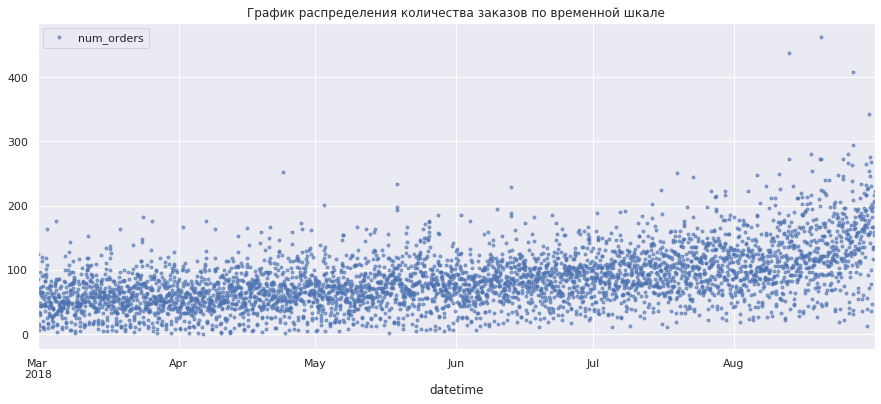

In [10]:
df.plot(marker='.', alpha=0.6, linestyle='None', title="График распределения количества заказов по временной шкале")

Здесь можно заметить тренд к очень неспешному в начале и чуть более скорому в июле-августе увеличению количества заказов. Видны особо отличившиеся значения в августе месяце, где среднее количество заказов за час почти достигает 80. Попробуем посмотреть подробнее на тренды и сезонность. Для этого разложим временной ряд на тренд, сезонность и остаток (шум), и посмотрим на их графики.

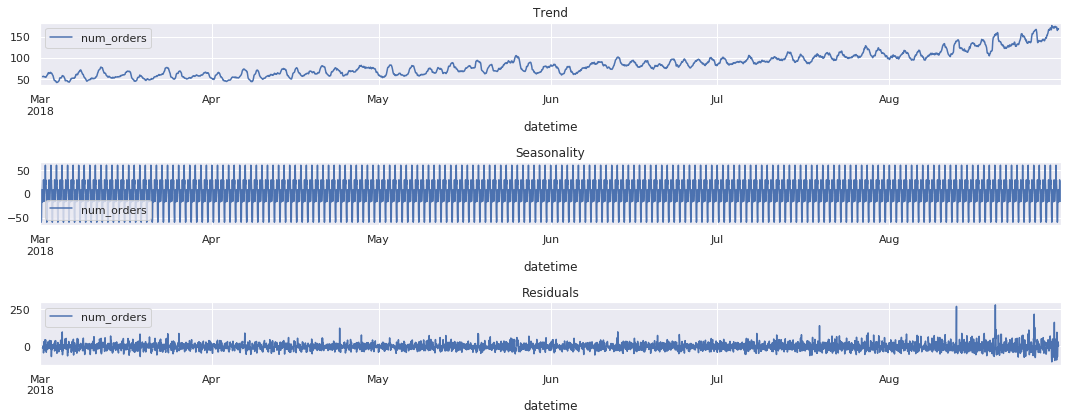

In [11]:
decomposed = seasonal_decompose(df)
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Тренд, как уже отметили выше, имеется, и скорее всего предсказуемо является ежегодным - в июле и августе растёт число отпусков. У нас данные всего за 1 год, поэтому для нас это тренд, а не сезонность) Но глобально для нашей задачи этот тренд не будет значимым, так как мы действуем в масштабе суток (и немножко недели), и условимся считать, что наш временной ряд стационарен.

Что касается действительно явления сезонности в нашем временном ряду, то она есть, и явно стабильная на всём протяжении ряда. Но нужно рассмотреть эти колебания поближе, это поможет в дальнейшем для подбора параметров моделей. Возьмём маленький кусок датасета и построим график сезонности для него.

Text(0.5, 1.0, 'Seasonality')

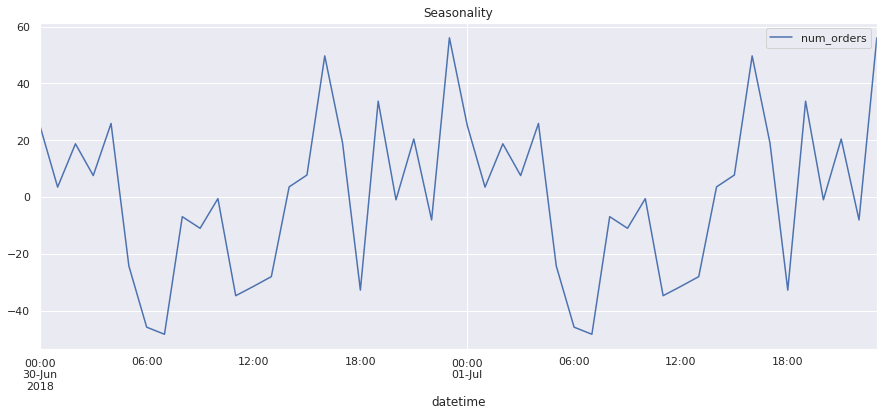

In [12]:
decomposed = seasonal_decompose(df['2018-06-30':'2018-07-01'])

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')


На графике суточной сезонности можно наблюдать три спада активности заказов - раннее утро, около полудня и 18 часов. 
Вероятно, это связано с группировкой рейсов на утренние, дневные и вечерние-ночные. Это хорошо бы учесть при создании модели и признаков, чтобы таксисты не думали, что потеряют заработок, если решат передохнуть и вздремнуть на парковке в 6 утра.

Также можно наблюдать, что вечером, ночью и под утро заказов явно больше, чем утром и днём. Ситуация была бы обратной, если бы наши данные были по заказам В аэропорт, а не ИЗ него. Здесь мы имеем дело с прилётами рейсов, и чаще всего они прилетают вечером и ночью. Итого: сезонность у нас получилась суточная, учтём это в работе с признаками.

Добавим к данным столбец с днями недели, чтобы пронаблюдать также ожидаемую недельную сезонность.

In [13]:
df['dayofweek'] = df.index.day_name()
df.head()

,num_orders,dayofweek
datetime,,
2018-03-01 00:00:00,124,Thursday
2018-03-01 01:00:00,85,Thursday
2018-03-01 02:00:00,71,Thursday
2018-03-01 03:00:00,66,Thursday
2018-03-01 04:00:00,43,Thursday


Text(0.5, 1.0, 'Распределение количества заказов по дням недели')

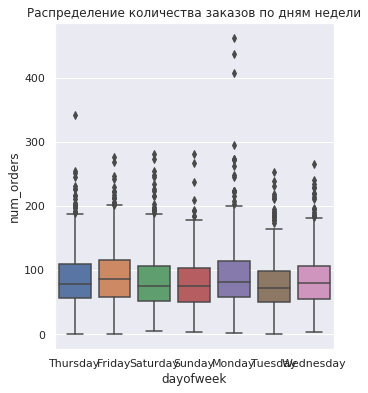

In [14]:
sns.set(rc={'figure.figsize':(5, 6)})
sns.boxplot(data=df, x='dayofweek', y='num_orders').set_title('Распределение количества заказов по дням недели')


По дням недели также есть отличия, больше всего заказов с началом и в конце рабочей недели. Этот момент машина должна учесть при обучении, используя столбец с днями недели (только надо не забыть заменить названия на циферки!).

# Машинное обучение временного ряда.

## Подготовка выборок

Делим выборку 9 к 1, не перемешивая, чтобы не нарушить хронологию, и чтобы не учить модель на данных из будущего.

In [15]:
# заменим дни недели на номера, чтобы не ходить за этим два раза после разделения выборок
df['dayofweek'] = df.index.dayofweek
# делим выборку
train, test = train_test_split(df, shuffle=False, test_size=0.1)

## Создание признаков. Обучение моделей. Поиск лучших.

Какие признаки мы можем добавить, чтобы они оказались полезными для обучения моделей?

- Что касается календарных, то кроме уже имеющегося дня недели, больше добавить нечего. Данные представлены меньше чем за год, поэтому использовать по месяцам - нецелесообразно, тем более, мы наблюдали не столь значительный тренд у двух последних месяцев, а все предыдущие и вовсе показали стабильное распределение.

- Будем использовать искусственые признаки "лаги" - это перенос значений целевого признака на определенный промежуток отставания. 

- И добавим "скользящее среднее", чтобы показать машинке, как в общем и целом движутся наши данные по временному ряду.

Для последних двух вариантов признаков необходимо подбирать параметры, поэтому мы включим этот подбор в функцию, которую применим на двух классических моделях машинного обучения: случайном лесе и линейной регрессии. 

Так как у нас наблюдалась суточная сезонность, логично использовать шаг перебора параметров в 24 часа, чтобы модель обучалась на других днях, но в том же времени суток.

In [16]:
# функция подбора лагов и окон скользящего среднего
# на вход модель и сет с данными
# на выходе RMSE, лаг и окно лучшей модели
def cv_time_series(model, df):
    best_max_lag = 0
    best_rolling = 0
    best_RMSE = 10000
    data = df.copy()

    #перебираем лаги и окна скользящего среднего с шагом в 24 часа, начиная со следующих суток:
    for roll in range(24, 100, 24):
        for lag in range(24, 100, 24):
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
            # делаем столбец со скользящим средним, перед этим шифтим, чтобы среднее от текущего не считалось
            data['rolling_mean'] = data['num_orders'].shift().rolling(roll).mean()
            data = data.dropna()
            #print(data.shape)
            features = data.drop('num_orders', axis=1)
            target = data['num_orders']
            # заряжаем кросс-валидацию для временных рядов! будет 5 разделений на тест и валид
            tscv = TimeSeriesSplit(n_splits=5)
            RMSE_cv = []
        
            # перебираем варианты разделения выборки
            for train_index, valid_index in tscv.split(features):
                X_train, X_valid = features.iloc[train_index], features.iloc[valid_index]
                y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
            
                model.fit(X_train, y_train)
                predictions = model.predict(X_valid)
                RMSE_cv.append((mean_squared_error(y_valid, predictions))**0.5)
                RMSE = np.mean(RMSE_cv)
            if RMSE < best_RMSE:
                best_RMSE = RMSE
                best_max_lag = lag
                best_rolling = roll
                    
    return best_RMSE, best_max_lag, best_rolling
    

        

Испробуем нашу функцию сначала на быстром варианте - линейной регрессии.

In [17]:
# это очень быстрый кусок кода, можно не уходить
LR = LinearRegression()
cv_LR = cv_time_series(LR, train)
print("\nЛучшая RMSE модели:", cv_LR[0], 
          "\nЛучший размер лага:", cv_LR[1], 
          "\nЛучшее окно скользящего среднего:", cv_LR[2])   



Лучшая RMSE модели: 24.84728038069273 
Лучший размер лага: 96 
Лучшее окно скользящего среднего: 24


Теперь проверим, существует ли такое суперудачное сочетание четырёх параметров (лаг, окно, глубина и кол-во оценщиков), что оно переплюнет RMSE линейной регрессии!

Сначала найдём хорошую глубину.

In [18]:
# это очень долгий цикл, можно сходить налить кофе!

# перебираем параметры случайного леса, а внутри перебираются лаги и окна скользящего среднего
best_of_the_best_RMSE = 10000
best_depth = 0


for depth in range(1, 21):
    RFR = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators=20)
    cv_RFR = cv_time_series(RFR, train)
    if cv_RFR[0] < best_of_the_best_RMSE:
        best_of_the_best_RMSE = cv_RFR[0]
        best_depth = RFR.get_params().get('max_depth')
print('Best depth =', best_depth)       

Best depth = 7


Теперь найдём лучшее количество оценщиков при глубине 7 и сохраним лаги и окна, давшие лучший результат.

In [19]:
# этот цикл тоже не блещет быстротой, но зато подберёт количество деревьев, да и кофе уже налит
best_of_the_best_RMSE = 10000
best_of_the_best_max_lag = 0
best_of_the_best_rolling = 0
best_est = 0

for est in range(1, 101, 10):
        RFR = RandomForestRegressor(random_state=42, max_depth=7, n_estimators=est)
        cv_RFR = cv_time_series(RFR, train)
        if cv_RFR[0] < best_of_the_best_RMSE:
            best_of_the_best_RMSE = cv_RFR[0]
            best_of_the_best_max_lag = cv_RFR[1]
            best_of_the_best_rolling = cv_RFR[2]
            best_est = RFR.get_params().get('n_estimators')

Барабанная дробь! Какое же у нас лучшее значение RMSE в случайном лесу?

In [20]:
print("\nЛучшая RMSE модели:", best_of_the_best_RMSE, 
          "\nЛучший размер лага:", best_of_the_best_max_lag, 
          "\nЛучшее окно скользящего среднего:", best_of_the_best_rolling,
     "\nЛучшая глубина деревьев:", best_depth,
     "\nЛучшее количество деревьев:", best_est)  


Лучшая RMSE модели: 25.030196100743847 
Лучший размер лага: 96 
Лучшее окно скользящего среднего: 24 
Лучшая глубина деревьев: 7 
Лучшее количество деревьев: 91


Проверили - и хорошо. Будем знать, что тут и линейная регрессия подойдёт. 

## Проверка лучшей модели на тестовой выборке. Выводы.

Итак, лучшие результаты у нас дала линейная регрессия обученная на дополнительных признаках, сформированных с лагом до четырёх суток и с окном скользящего среднего размером в трое суток. Применим эти знания на тестовой выборке и узнаем RMSE предсказаний на этих данных.

Воссоздадим для обучающей и создадим для тестовой признаки, исходя из найденных параметров. Важно также перенести пропущенные значения из обучающей выборки, иначе получится очень мало объектов после удаления пропусков.

In [21]:
test_check = test.copy()
train_check = train.copy()
for lag in range(24, 97, 24):
    test_check['lag_{}'.format(lag)] = test_check['num_orders'].shift(lag)
    train_check['lag_{}'.format(lag)] = train_check['num_orders'].shift(lag)

test_check['rolling_mean'] = test_check['num_orders'].shift().rolling(24).mean()
test_check = test_check.dropna()

train_check['rolling_mean'] = train_check['num_orders'].shift().rolling(24).mean()
train_check = train_check.dropna()

features_test = test_check.drop('num_orders', axis=1)
target_test = test_check['num_orders']
features_train = train_check.drop('num_orders', axis=1)
target_train = train_check['num_orders']
features_test.head()

,dayofweek,lag_24,lag_48,lag_72,lag_96,rolling_mean
datetime,,,,,,
2018-08-17 14:00:00,4,64.0,107.0,112.0,102.0,128.125000
2018-08-17 15:00:00,4,110.0,103.0,116.0,175.0,130.708333
2018-08-17 16:00:00,4,190.0,219.0,111.0,144.0,130.458333
2018-08-17 17:00:00,4,191.0,165.0,152.0,152.0,131.041667
2018-08-17 18:00:00,4,111.0,96.0,98.0,104.0,129.958333


Обучим модель на обучающей и предскажем целевой признак на тестовой выборках. Вычислим RMSE.

In [22]:
LR.fit(features_train, target_train)
predictions_test = LR.predict(features_test)
print("RMSE модели лучшей модели линейной регрессии \nс лагом в 96 часов \nи окном скользящего среднего в 24 часа:\n", 
     ((mean_squared_error(target_test, predictions_test))**0.5))

RMSE модели лучшей модели линейной регрессии 
с лагом в 96 часов 
и окном скользящего среднего в 24 часа:
 43.764822037862835


Ошибка взлетела в два раза, на то они и тестовые данные. Модель получилась в меру обученной (не недо- и не пере-). 

<b>Итого:</b>

Иногда простые модели побеждают более хитрых товарищей. Здесь как раз тот случай: линейная регрессия в сочетании с оптимальным подбором признаков дала наилучший результат. Недельная цикличность учитывалась признаком, содержащим дни недели, суточная была учтена при создании отстающих столбцов и скользящего среднего, где лучшие результаты показали отставания от одного до четырёх дней, а также скользящие средние вычисленные за трое суток с шагом в сутки (то есть среднее по данному часу за три дня).

Спасибо.